ratio:  10
R:  0.9006430410565854
directness= 1
alpha: 1000 must be greater than 500
h coarse: 24.0


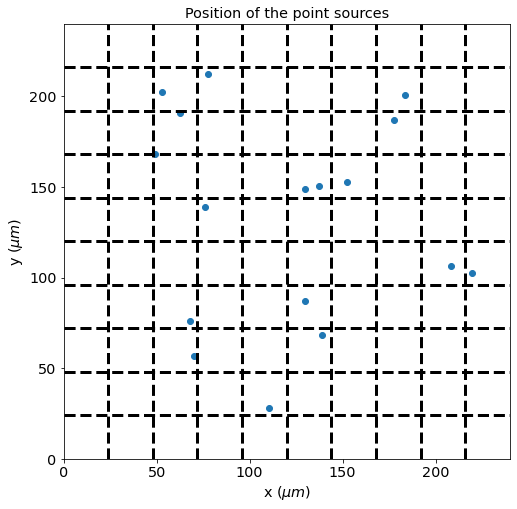

In [1]:
import pdb
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8,8 ),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth': 3}
pylab.rcParams.update(params)


#0-Set up the sources
#1-Set up the domain
alpha=1000

Da_t=10

D=1
C0=1


L=240

M=Da_t*D/L**2
phi_0=0.4
cells=10
h_ss=L/cells
ratio=int(50/cells)*2
print("ratio: ", ratio)
#ratio=12
#Rv=np.exp(-2*np.pi)*h_ss


print("R: ", 1/(1/C0 + np.log(alpha/(5*cells*ratio))/(2*np.pi*D)))


conver_residual=5e-5

stabilization=0.5

validation=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(np.around(L/h_ss)))
y_ss=x_ss
directness=1
print("directness=", directness)
#pos_s=np.array([[x_ss[2], y_ss[2]],[x_ss[4], y_ss[4]]])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[2,2]])-np.array([0.25,0.25])
#pos_s/=2
#pos_s=np.array([[1.25,1.25],[1.25,1.75], [1.75,1.75],[1.75,1.25]])
#pos_s=np.array([[4.3,4.3],[4.3,5.5], [3.5,4.5],[3.5,3.5]])


#pos_s=np.array([[0.41,0.41],[0.7,0.7],[0.3,0.47],[0.8,0.2]])*L
pos_s=np.array([[0.47,0.47],[0.53,0.53]])*L
pos_s1=np.array([[0.45,0.02],[0.24,0.17],[0.6,0.23],[0.23,0.27],[0.55,0.33],[1.02,0.41],[0.96,0.43]])
pos_s2=np.array([[0.27,0.6],[0.55,0.65],[0.59,0.66],[0.67,0.67],[0.13,0.75],[0.15,0.93],[0.2,0.87],[0.28,0.98],[0.8,0.85],[0.83,0.92]])
pos_s=(np.concatenate((pos_s1, pos_s2))*0.8+0.1)*L
#pos_s=(np.array([[0.45,0.02],[0.24,0.17],[0.6,0.23],[0.23,0.27],[0.55,0.33],[1.02,0.41],[0.96,0.43]])*0.6+0.2)*L
#pos_s=np.array([[0.5,0.5]])*L
#pos_s=(np.random.random((6,2))*0.6+0.2)*L




S=len(pos_s)
Rv=L/alpha+np.zeros(S)

print("alpha: {} must be greater than {}".format(alpha, 5*ratio*cells))
print("h coarse:",h_ss)
K_eff=C0/(np.pi*Rv**2)
#Position image

vline=(y_ss[1:]+x_ss[:-1])/2
plt.scatter(pos_s[:,0], pos_s[:,1])
plt.title("Position of the point sources")
for xc in vline:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in vline:
    plt.axhline(y=xc, color='k', linestyle='--')
plt.xlim([0,L])
plt.ylim([0,L])
plt.ylabel("y ($\mu m$)")
plt.xlabel("x ($\mu m$)")
plt.show()


p=np.linspace(0,1,100)
if np.min(p-M*(1-phi_0/(phi_0+p)))<0: print("There is an error in the metabolism")


C_v_array=np.ones(S)   

In [2]:
FV=FV_validation(L, cells*ratio, pos_s, C_v_array, D, K_eff, Rv)
FV_linear=FV.solve_linear_system()
FV_linear_rcr=FV_linear.copy()
FV_linear_rcr[FV.s_blocks]+=FV.get_corr_array(FV_linear)

FV_linear_mat=FV_linear.reshape(cells*ratio, cells*ratio)
FV_linear_rcr_mat=FV_linear_rcr.reshape(cells*ratio, cells*ratio)

#%%
print("R: ", 1/(1/C0 + np.log(0.2*FV.h/Rv)/(2*np.pi*D)))



R: [0.90064304 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304
 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304
 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304]
R:  [0.90064304 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304
 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304
 0.90064304 0.90064304 0.90064304 0.90064304 0.90064304]


In [3]:
FV.get_corr_array(FV_linear)

array([-0.03805162, -0.03159098, -0.02781804, -0.02931042, -0.02444928,
       -0.03856237, -0.03389194, -0.02636424, -0.02045219, -0.02012859,
       -0.02316577, -0.03055745, -0.03323071, -0.0284091 , -0.03568168,
       -0.03097045, -0.03502359])

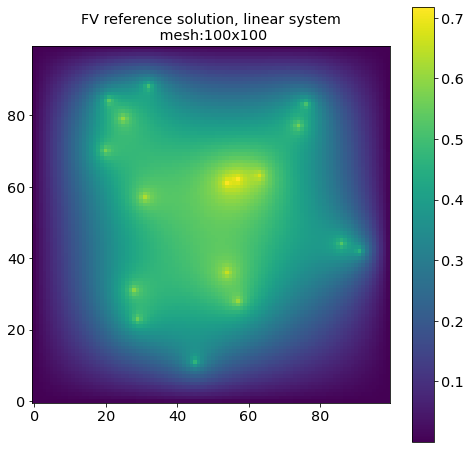

In [4]:
#%% Plots FV reference solution - Peaceman Coupling

plt.imshow(FV_linear_rcr_mat, origin='lower')
plt.colorbar()
plt.title("FV reference solution, linear system\n mesh:{}x{}".format(ratio*cells, ratio*cells))
plt.show()




In [5]:
#Linear system with coupling model
n=non_linear_metab(pos_s, Rv, h_ss, L, K_eff, D, directness)
n.solve_linear_prob(np.zeros(4), C_v_array)



inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support
inside each others support


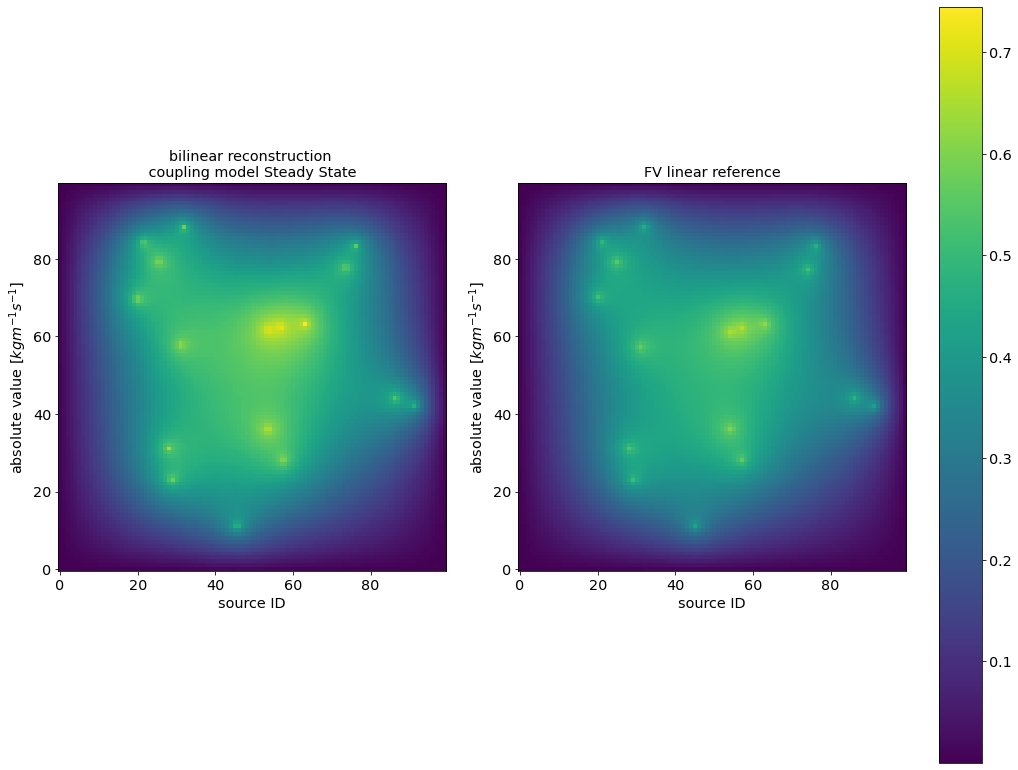

In [6]:
b=post.reconstruction_sans_flux(np.concatenate((np.ndarray.flatten(n.phi_FV), n.phi_q)), n, L,ratio, directness)
p=b.reconstruction()   
b.reconstruction_boundaries(np.array([0,0,0,0]))
b.rec_corners()

fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
im=axs[0].imshow(b.rec_final, origin='lower')
axs[0].set_title("bilinear reconstruction \n coupling model Steady State ")
axs[0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[0].set_xlabel("source ID")


axs[1].imshow(FV_linear_rcr_mat, origin='lower',vmax=np.max(FV_linear_mat*1.1))
axs[1].set_title("FV linear reference")
axs[1].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1].set_xlabel("source ID")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)


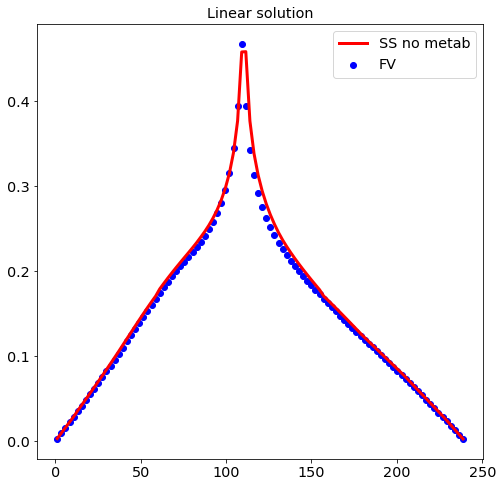

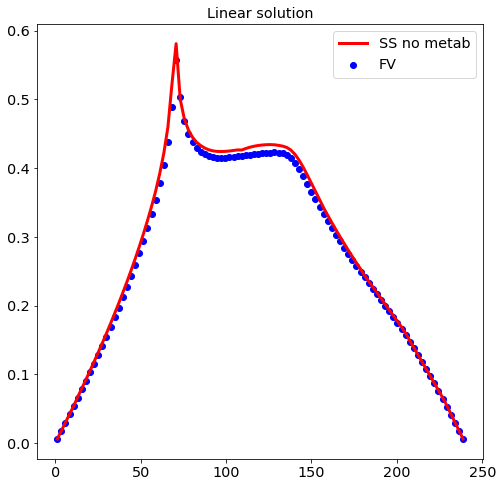

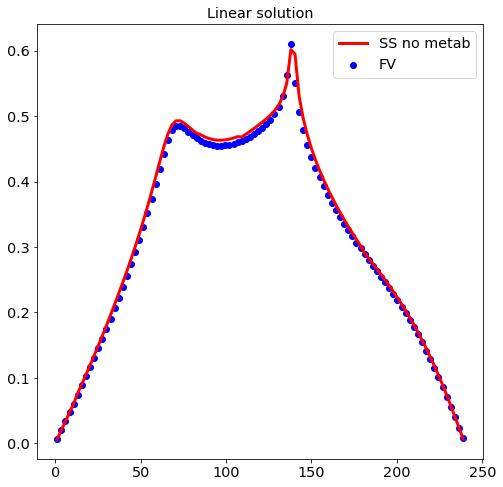

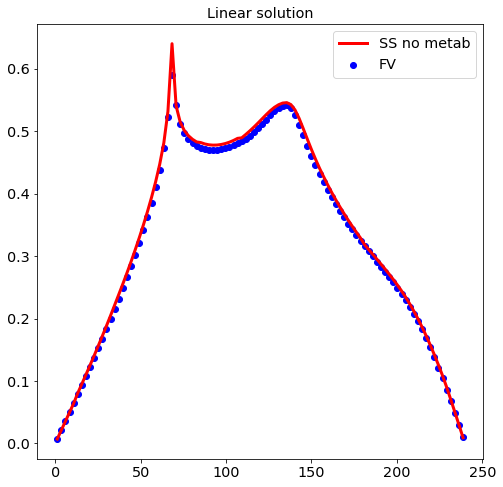

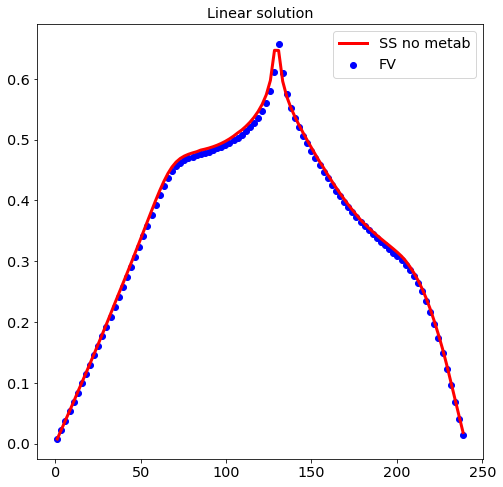

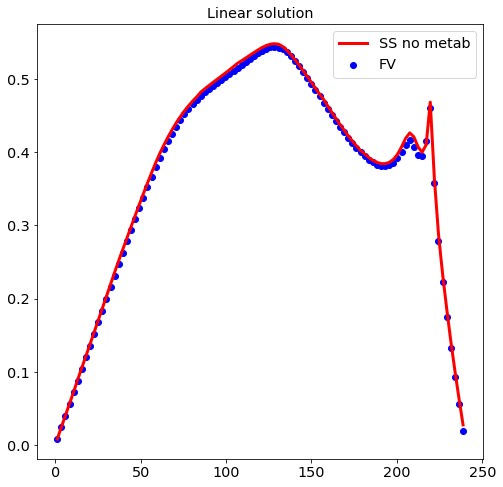

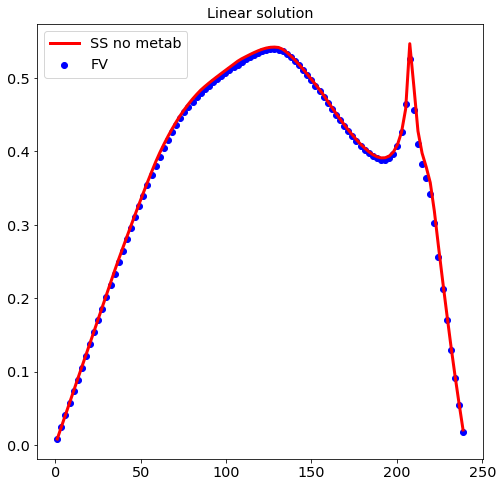

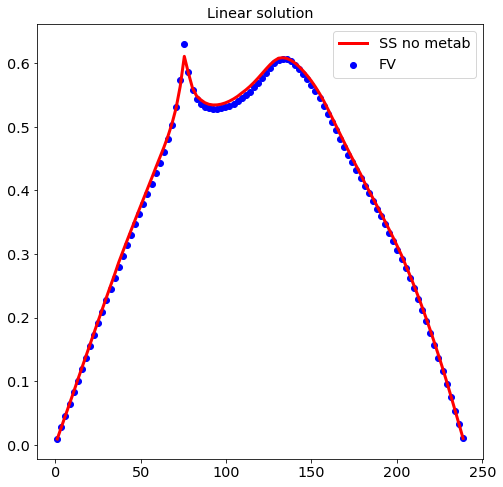

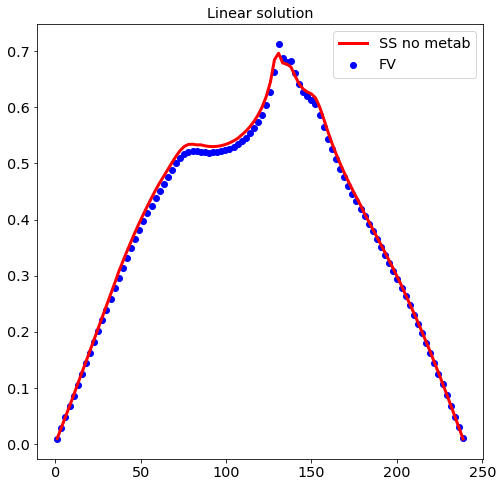

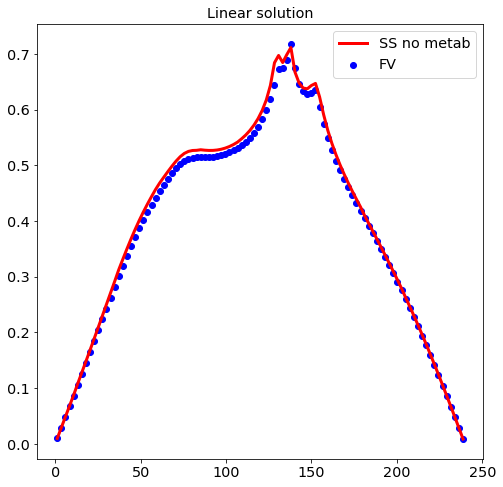

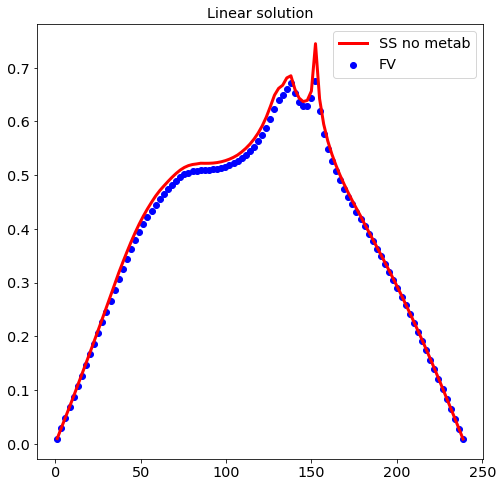

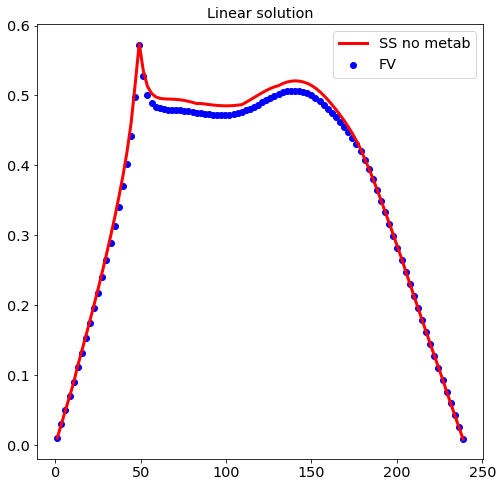

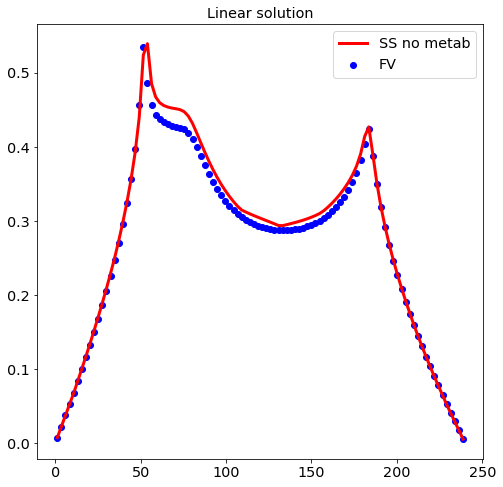

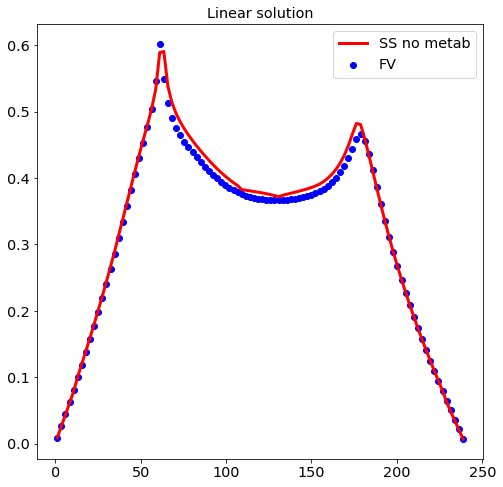

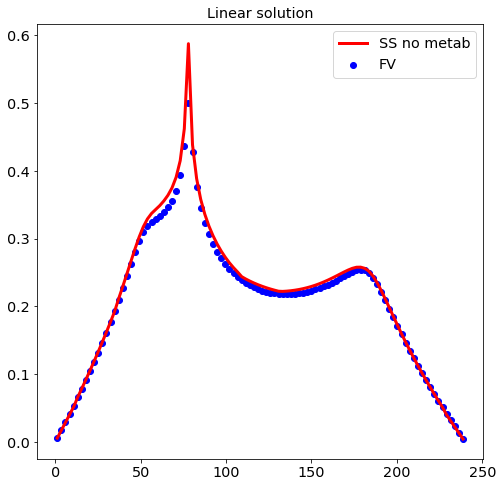

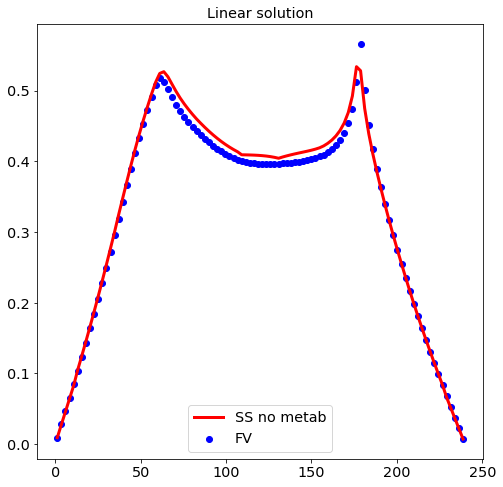

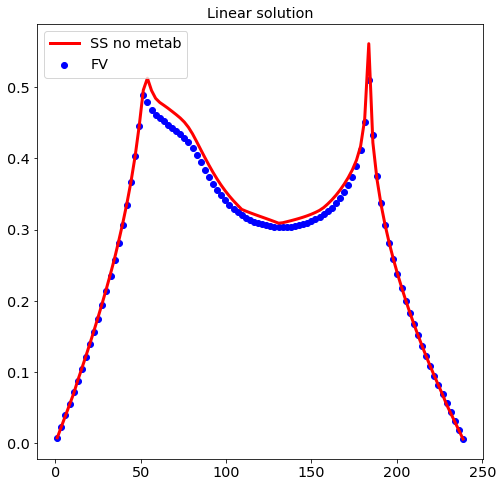

In [7]:
#manual q
q_array_linear=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV_linear)*FV.h**2/D
for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    
    plt.scatter(FV.x,FV_linear_rcr_mat[pos//len(FV.x),:], label="FV", color='b')
    plt.plot(FV.x,b.rec_final[pos//len(FV.x),:],label="SS no metab", color='r')
    plt.legend()
    plt.title("Linear solution")
    plt.show()

Residual q FV:  0.11621409822457338
Residual q FV:  0.04735854951112734
Residual q FV:  0.019176321719785037
Residual q FV:  0.007751003940739412
Residual q FV:  0.0031375710722409207
Residual q FV:  0.0012778083274692996
Residual q FV:  0.0005341461970979151
Residual q FV:  0.0002246476262025459
Residual q FV:  9.510740688295838e-05
Residual q FV:  4.054972361791348e-05


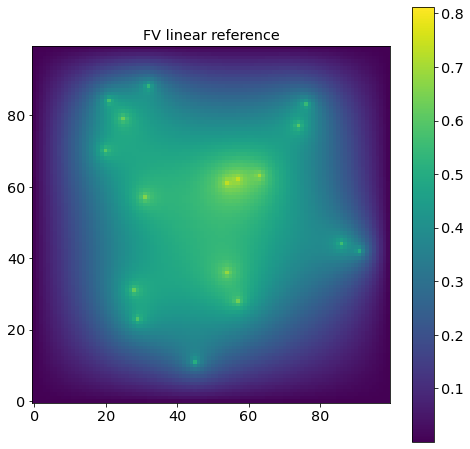

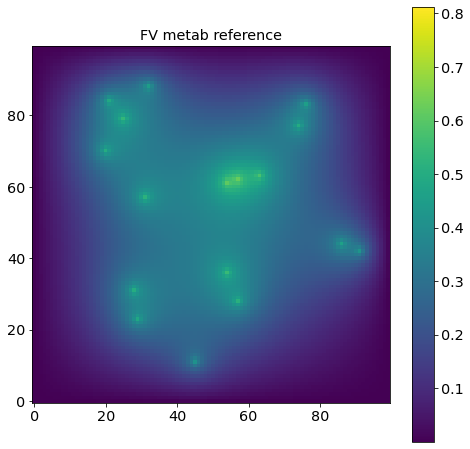

In [8]:
#%% 5
FV_non_linear=FV.solve_non_linear_system(phi_0,M, stabilization)
#phi_FV=FV_linear.reshape(cells*ratio, cells*ratio)
phi_FV=(FV.phi[-1]+FV.Corr_array).reshape(cells*ratio, cells*ratio)


#%%

plt.imshow(FV_linear_mat, origin='lower',vmax=np.max(FV_linear_mat*1.1))
plt.title("FV linear reference")
plt.colorbar(); plt.show()


#%%
plt.imshow(phi_FV, origin='lower', vmax=np.max(FV_linear_mat*1.1))
plt.title("FV metab reference")
plt.colorbar(); plt.show()


#manual q
q_array=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV.phi[-1])*FV.h**2/D+M*(1-phi_0/(FV.phi[-1, FV.s_blocks]+FV.Corr_array[FV.s_blocks]+phi_0))

In [9]:
#manual q
q_array=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV.phi[-1])*FV.h**2/D+M*(1-phi_0/(FV.phi[-1, FV.s_blocks]+FV.Corr_array[FV.s_blocks]+phi_0))


MRE steady state system 0.0461099253770316


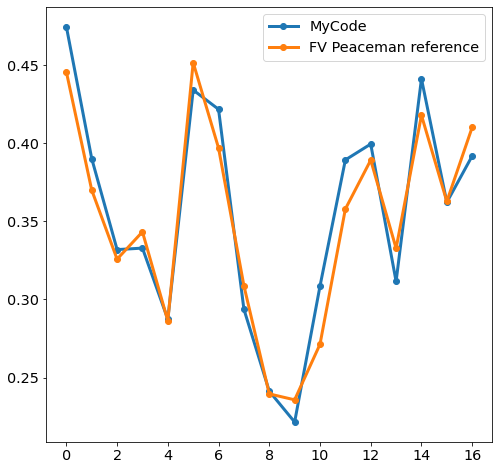

In [10]:
print("MRE steady state system", get_MRE(n.phi_q, FV.get_q(FV_linear)))

plt.plot(np.arange(S),n.phi_q, label="MyCode", marker='o')
plt.plot(np.arange(S),FV.get_q(FV_linear), label="FV Peaceman reference", marker='o')
plt.legend()
plt.show()


residual 0.016124992096002953
residual 0.008572143216768222
residual 0.005052900692141781
residual 0.0031073700565504374
residual 0.0019580502469958364
residual 0.001252643369746554
residual 0.0008088706898808765
residual 0.000525678247550003
residual 0.00034307480709994234
residual 0.00022452552579009752
residual 0.00014721811610094322
residual 9.665546217155896e-05
residual 6.351742207995304e-05
residual 4.176822333469256e-05


()

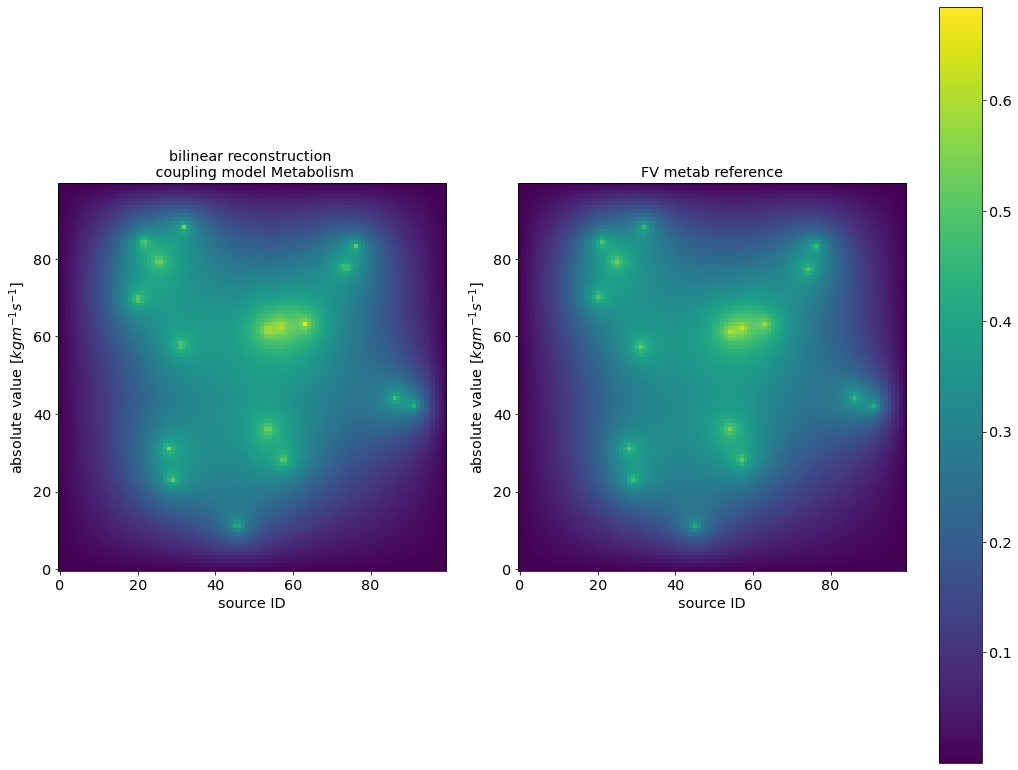

In [11]:
n.Full_Newton(np.ndarray.flatten(n.phi_FV) , np.ndarray.flatten(n.phi_q), conver_residual, M, phi_0)
a=post.reconstruction_sans_flux(n.phi[-1], n, L,ratio, directness)
p=a.reconstruction()   
a.reconstruction_boundaries(np.array([0,0,0,0]))
a.rec_corners()


fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
im=axs[0].imshow(a.rec_final, origin='lower', vmax=np.max(phi_FV*1.1))
axs[0].set_title("bilinear reconstruction \n coupling model Metabolism")
axs[0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[0].set_xlabel("source ID")

axs[1].imshow(phi_FV, origin='lower', vmax=np.max(phi_FV*1.1))
axs[1].set_title("FV metab reference")
axs[1].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1].set_xlabel("source ID")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)

n.assemble_it_matrices_Sampson(n.u, n.q)


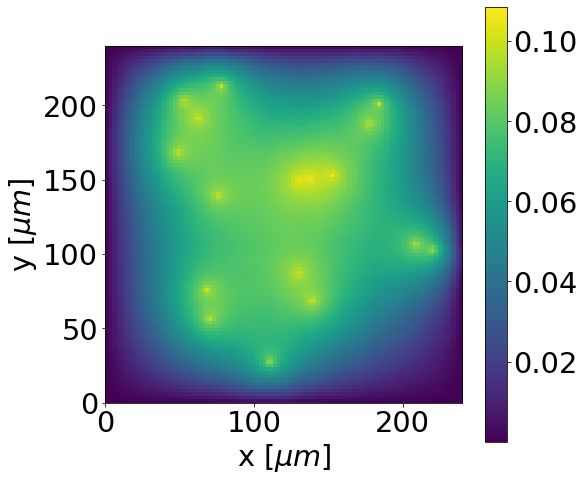

In [12]:
plt.rcParams['font.size'] = '20'
plt.imshow(a.rec_final/(a.rec_final+phi_0)*(ratio*cells/L)**2, origin='lower', extent=[0,L,0,L])
#plt.title("metabolism")
plt.ylabel("y [$\mu m$]")
plt.xlabel("x [$\mu m$]")
plt.colorbar()


In [13]:
M


0.00017361111111111112

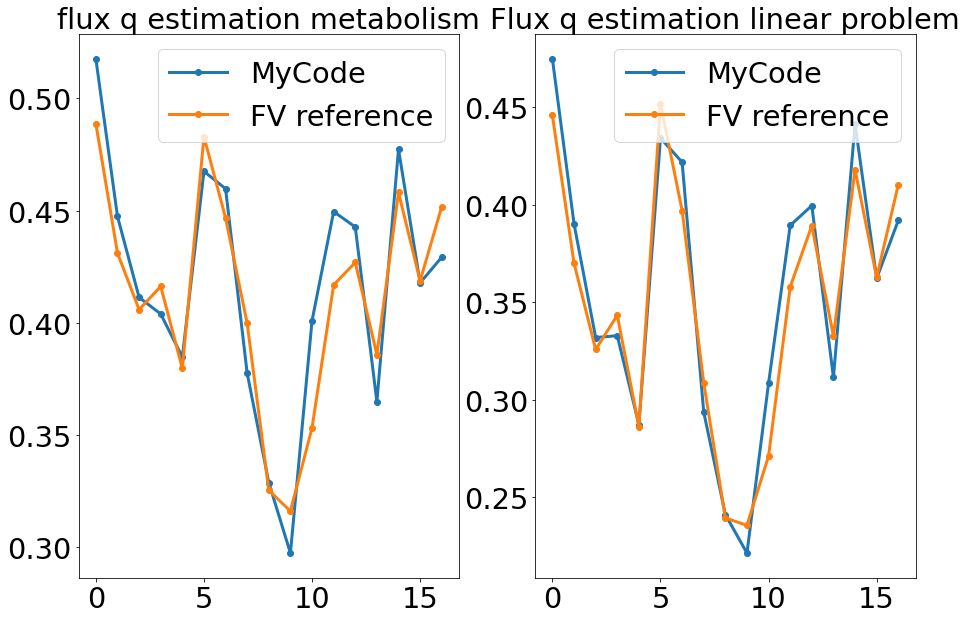


MRE q estimation non_linear 0.042556303284792

MRE q estimation linear 0.0461099253770316


In [14]:

plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(n.phi[-1,-S:], label="MyCode", marker='o')
plt.plot(FV.get_q(FV.phi[-1]), label="FV reference", marker='o')
plt.title("flux q estimation metabolism")
plt.legend()
plt.subplot(1,2,2)
plt.plot(n.phi_q, label="MyCode", marker='o')
plt.plot(FV.get_q(FV_linear), label="FV reference", marker='o')
plt.legend()
plt.title("Flux q estimation linear problem")
plt.show()

print("\nMRE q estimation non_linear", get_MRE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))
print("\nMRE q estimation linear", get_MRE(n.phi_q, FV.get_q(FV_linear)))





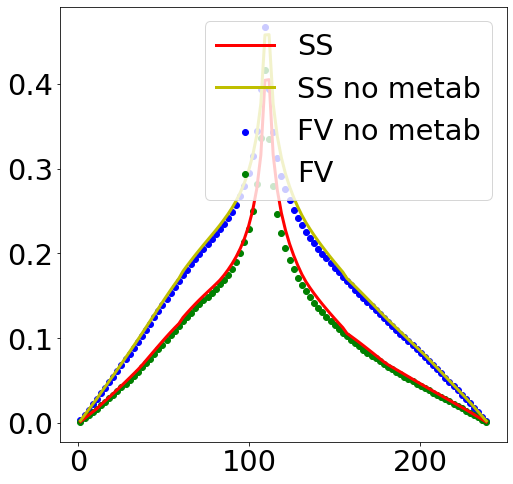

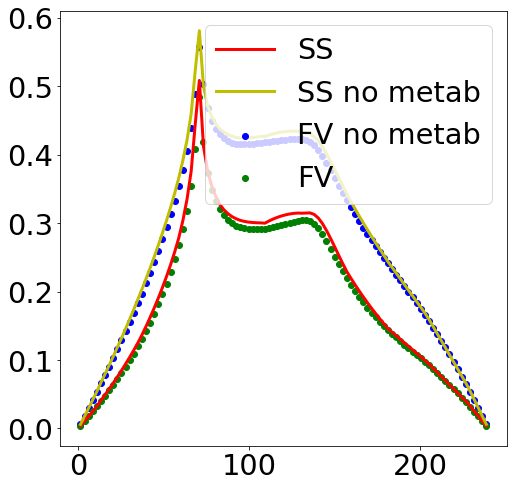

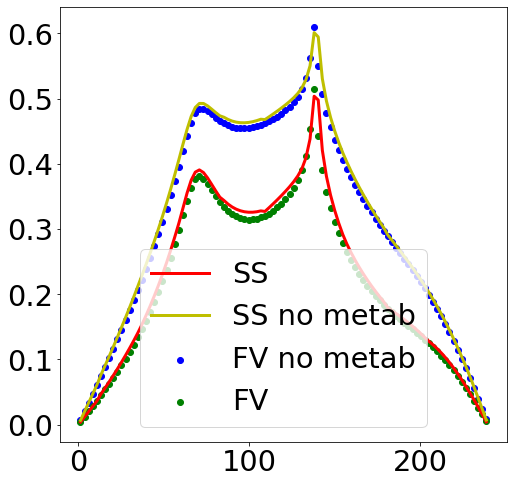

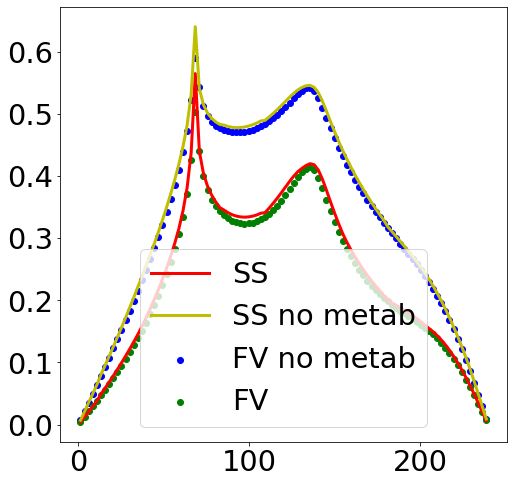

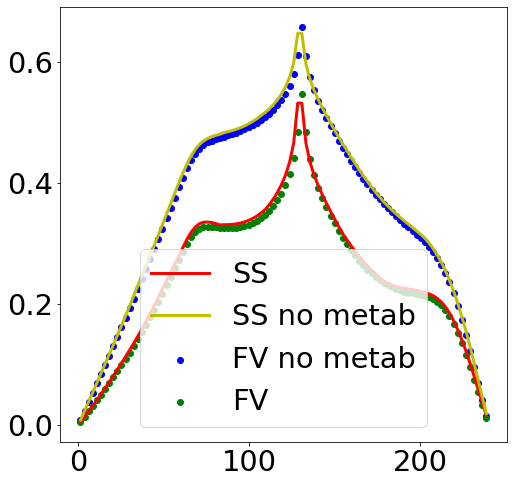

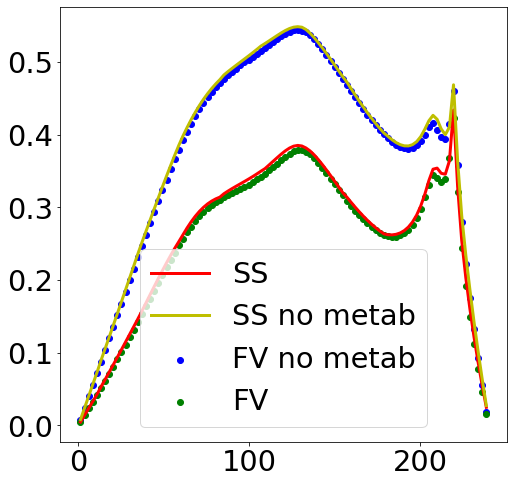

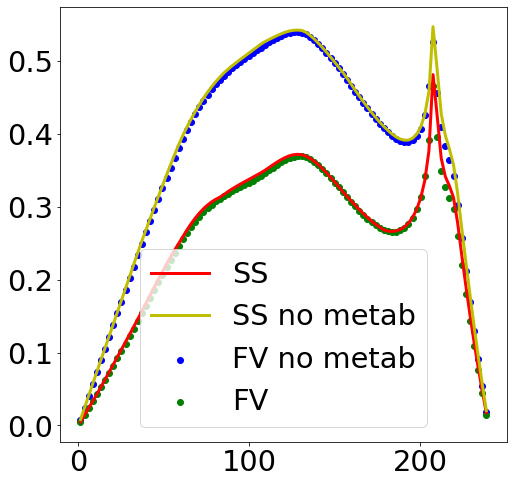

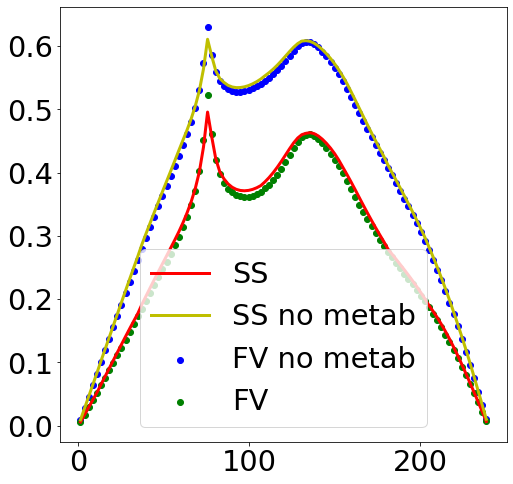

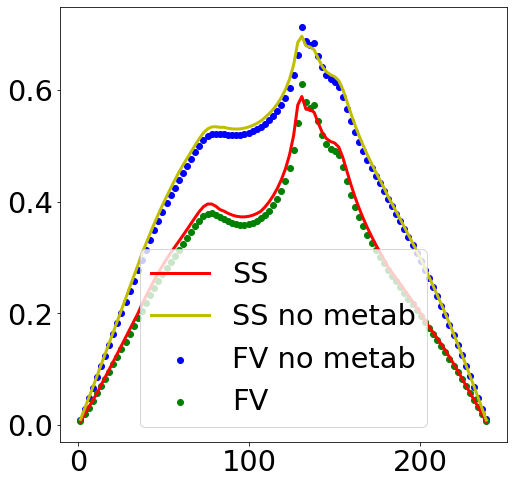

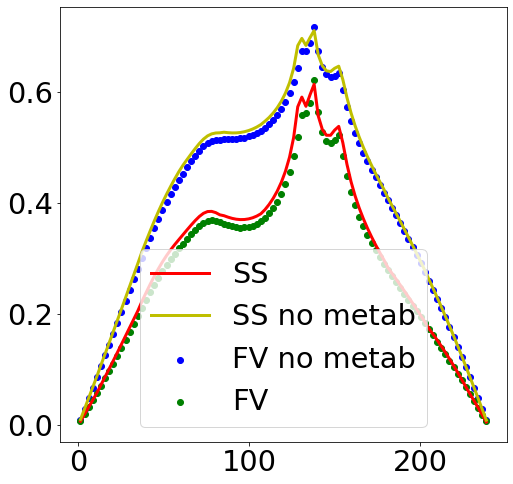

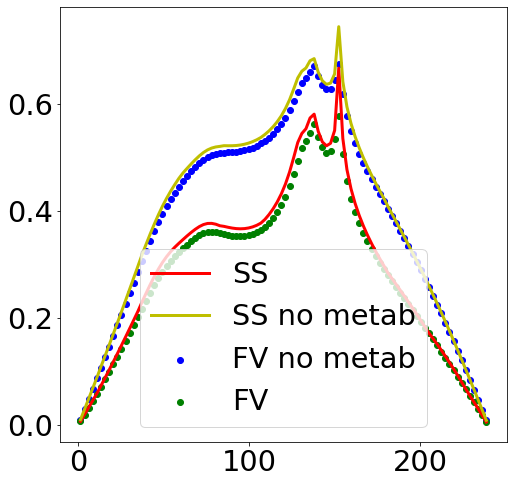

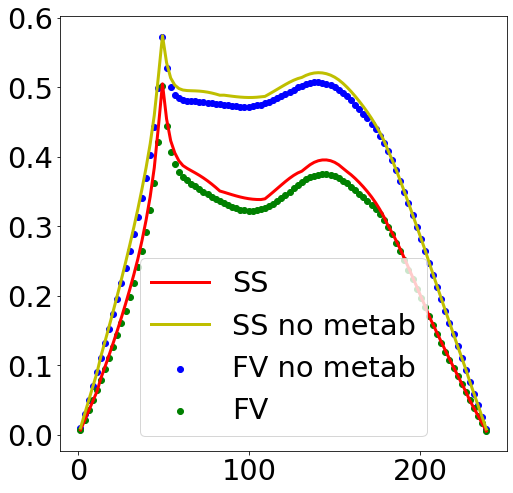

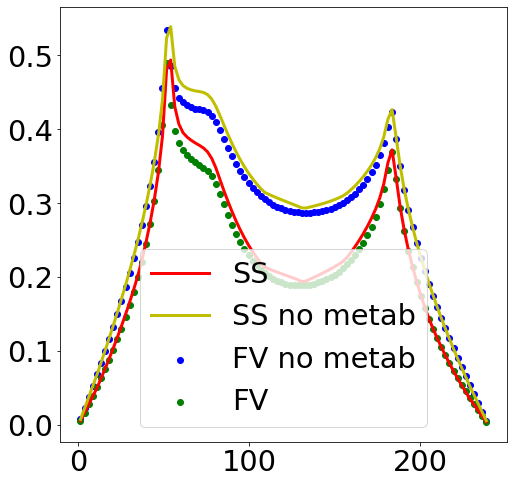

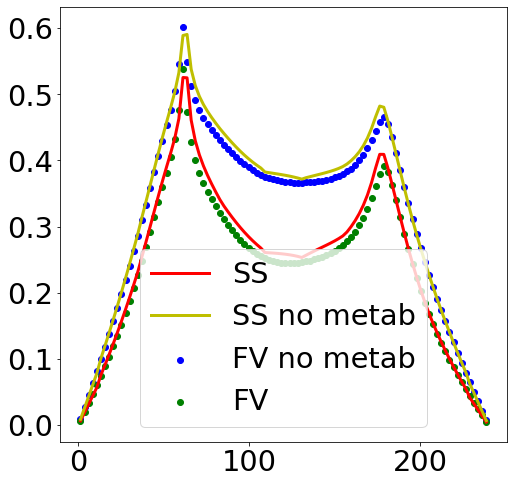

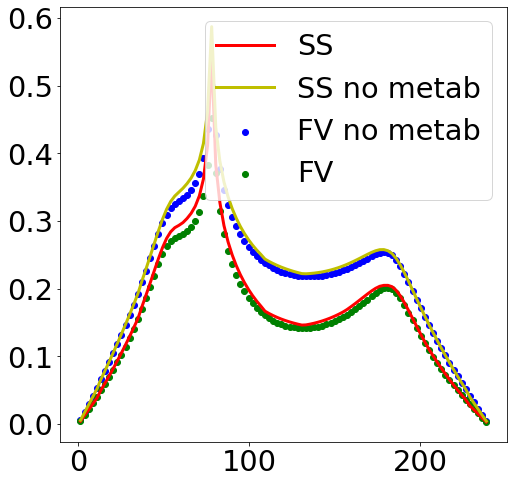

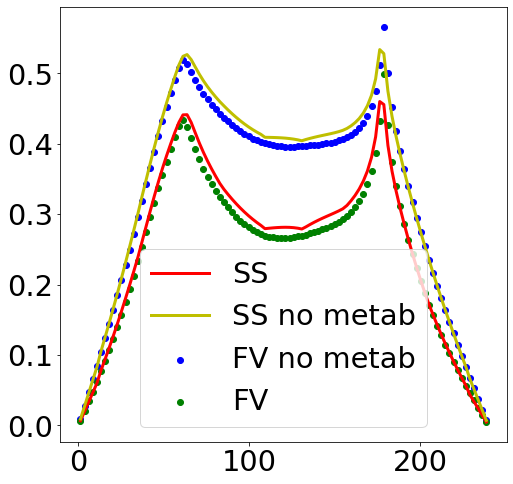

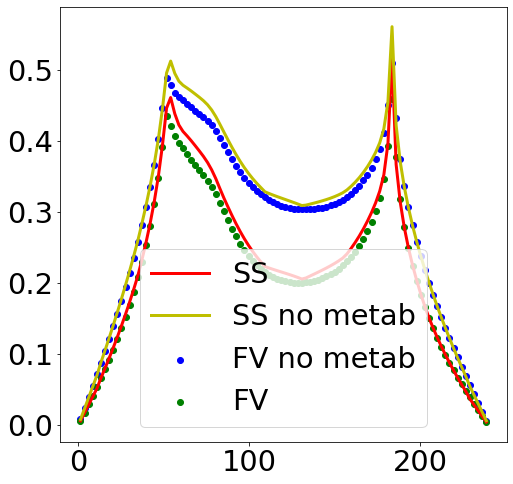

In [15]:
for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    
    plt.scatter(FV.x,FV_linear_rcr_mat[pos//len(FV.x),:], label="FV no metab", marker='o', color='b')
    plt.scatter(FV.x,phi_FV[pos//len(FV.x),:], label="FV", marker='o',color='g')
    plt.plot(FV.x,a.rec_final[pos//len(FV.x),:],label="SS", color='r')
    plt.plot(FV.x,b.rec_final[pos//len(FV.x),:],label="SS no metab", color='y')
    plt.legend()
    plt.show()

# =============================================================================
# c=0
# for i in pos_s:
#     pos=coord_to_pos(FV.x, FV.y, i)
#     
#     plt.plot(FV.x,phi_FV[pos//len(FV.x),:], label="FV")
#     plt.scatter(n.x,(n.rec_sing+n.u).reshape(cells, cells)[n.s_blocks[c]//cells,:],label="SS")
#     plt.plot(b.x,b.rec_final[pos//len(FV.x),:],label="SS no metab")
#     plt.legend()
#     plt.show()
#     c+=1
# =============================================================================



In [16]:
print("relative errors in the q estimation metabolism")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1]))/FV.get_q(FV.phi[-1]))

print("\nabsolute error in the q estimation metabolism")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1])))

print("\nL2_error in the q estimation metabolism")
print(get_L2(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))

print("\nMRE q estimation non_linear", get_MRE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))
print("\nMRE q estimation linear", get_MRE(n.phi_q, FV.get_q(FV_linear)))





relative errors in the q estimation metabolism
[0.05907654 0.03790227 0.01339636 0.02959297 0.01328348 0.03201288
 0.02914206 0.05575241 0.01063065 0.05933192 0.13547611 0.07852161
 0.03703882 0.05438332 0.04206966 0.002021   0.04994241]

absolute error in the q estimation metabolism
[0.02887491 0.01633681 0.00543639 0.01231496 0.00504194 0.01546027
 0.01301772 0.02228039 0.00345632 0.0187417  0.04782109 0.03272711
 0.01580931 0.02097397 0.01927043 0.00084596 0.02255981]

L2_error in the q estimation metabolism
0.050056287909299585

MRE q estimation non_linear 0.042556303284792

MRE q estimation linear 0.0461099253770316
